<body bgcolor="#E6E6FA">
  <div>  <img src="https://netbramha.com/wp-content/uploads/2016/12/senior-front-end-developer-openings-1.gif" align=left width=300px height=300px><h1>&nbsp;&nbsp;&nbsp;&nbsp; Python <br> &nbsp;&nbsp;&nbsp;&nbsp; Innowatts - Data Scientist Coding Assignment
 <br> <br>&nbsp;&nbsp;&nbsp;&nbsp; Test 7-Year Survival Prediction  Analysis File </h1><img src='' align=right width=200px height=100px>
</div>

In [1]:
## Importing the data and module--->

import re
import pickle
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score,precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Reading the File data

In [2]:
# diagnosis_date	the month and year of diagnosis
# gleason_score	A measurement of how abnormal the cancer cells look compared to normal cells
# t_score	Describes local extent of prostate tumor
# n_score	Describes whether or not the cancer has spread to the lymph nodes
# m_score	Describes whether or not the cancer has spread to distant parts of the body
# stage	Stage of cancer
# age	Age of patient at time of diagnosis
# race	Race of patient
# height	Height of patient at time of diagnosis
# weight	Weight of patient at time of diagnosis
# family_history	count of family members who have been diagnosed with prostate cancer
# first_degree_history	count of brothers and fathers of the patient who have been diagnosed with prostate cancer
# previous_cancer	flag indicating whether the patient has ever been diagnosed with any cancer previously
# smoker	flag indicating whether the patient describes himself as a smoker
# side	What side of the prostate the cancer has been found in
# tumor_diagnosis	Size of primary tumor at time of diagnosis, in mm
# tumor_6_months	Size of primary tumor 6 months after diagnosis, in mm
# tumor_1_year	Size of primary tumor 1 year after diagnosis, in mm
# psa_diagnosis	Level of prostate-specific antigen in blood at time of diagnosis, in ng/mL
# psa_6_months	Level of prostate-specific antigen in blood 6 months after diagnosis, in ng/mL
# psa_1_year	Level of prostate-specific antigen in blood 1 year after diagnosis, in ng/mL
# tea	How many times the patient reports drinking tea per week
# symptoms	A list of codes indicating the presence of various symptoms. The meaning of the codes has been removed.
# rd_thrpy	external beam radiotherapy used
# h_thrpy	hormone therapy used
# chm_thrpy	chemotherapy used
# cry_thrpy	crypotherapy used
# brch_thrpy	brachytherapy used
# rad_rem	prostate surgically removed
# multi_thrpy	multiple therapies used in conjunction
# survival_1_year	survived 1 year from diagnosis flag
# survival_7_years	survived 7 years from diagnosis flag


In [3]:
# Reading Both Data and will work in parallel ---->

test=pd.read_csv(r'C:\Users\HP\DS_Candidate_Test\test.csv')
train=pd.read_csv(r'C:\Users\HP\DS_Candidate_Test\train.csv')

# Distribution of "Target"

In [4]:
# Checking Distribution of "Target" ---->

train.survival_7_years.value_counts(normalize=True,dropna=True)

0    0.567814
1    0.432186
Name: survival_7_years, dtype: float64

In [5]:
# Shape ---->

print(f'Train DataFrame Shape is {train.shape} and Test DataFrame Shape is {test.shape}')

Train DataFrame Shape is (14385, 33) and Test DataFrame Shape is (1000, 33)


In [6]:
# train[['tumor_diagnosis','tumor_6_months','tumor_1_year','survival_7_years']].corr()
# train[['psa_6_months','psa_diagnosis','psa_1_year','survival_7_years']].corr()
# train[(train['psa_diagnosis'].isna())&~(train['psa_6_months'].isna())].shape
# train[(train['tumor_diagnosis'].isna())&~(train['tumor_6_months'].isna())].shape
# train[(train['psa_1_year'].isna())&~(train['psa_6_months'].isna())].shape
# train[(train['tumor_1_year'].isna())&~(train['tumor_6_months'].isna())].shape
# train[(train['tumor_diagnosis'].isna())&~(train['tumor_1_year'].isna())].shape
# train[(train['psa_diagnosis'].isna())&~(train['psa_1_year'].isna())].shape

# Assumption  

In [7]:
#==Assumption 
    # 1) if a person have a unknown value on tumor_diagnosis or tumor_1_year 
    #     we can fill them by tumor_6_months/tumor_1_year/tumor_diagnosis considring that the person might get the same level 
    #     of infection after/before 6 month

    # 2) Weight : in lbs

    # 3) height : in inches

    # we can go with either side like filling 0 level data to 1 year data

train['tumor_6_months'].fillna(train['tumor_diagnosis'],inplace=True)
train['tumor_1_year'].fillna(train['tumor_6_months'],inplace=True)  

train['tumor_6_months'].fillna(train['tumor_1_year'],inplace=True)
train['tumor_diagnosis'].fillna(train['tumor_6_months'],inplace=True)

train['psa_6_months'].fillna(train['psa_diagnosis'],inplace=True)
train['psa_1_year'].fillna(train['psa_6_months'],inplace=True)

train['psa_6_months'].fillna(train['psa_1_year'],inplace=True)
train['psa_diagnosis'].fillna(train['psa_6_months'],inplace=True)


test['tumor_6_months'].fillna(test['tumor_diagnosis'],inplace=True)
test['tumor_1_year'].fillna(test['tumor_6_months'],inplace=True)

test['tumor_6_months'].fillna(test['tumor_1_year'],inplace=True)
test['tumor_diagnosis'].fillna(test['tumor_6_months'],inplace=True)

test['psa_6_months'].fillna(test['psa_diagnosis'],inplace=True)
test['psa_1_year'].fillna(test['psa_6_months'],inplace=True)

test['psa_6_months'].fillna(test['psa_1_year'],inplace=True)
test['psa_diagnosis'].fillna(test['psa_6_months'],inplace=True)

In [8]:
# Creating Diff indicator b/w psa_diagnosis & psa_1_year 
# which will represent increse and decrese in size at claim level 

train['psa_inc']=(train['psa_1_year']-train['psa_diagnosis'])
train['psa_inc'].fillna(0,inplace=True)

test['psa_inc']=(test['psa_1_year']-test['psa_diagnosis'])
test['psa_inc'].fillna(0,inplace=True)

In [9]:
train['tumor_inc']=(train['tumor_1_year']-train['tumor_diagnosis'])

In [10]:
# for all tumor_inc_flag==+ there is increse in defect/injury/tumor
# for all psa_inc_flag==+ there is increse in prostate-specific antigen

# creating flag 
# Tried Percentile method but didn't work so I am creating only -1,0,+1 
# np.where can we reduce like i have created 2 caterogy for >0 --> 1 we can make it to 1 caterogy but I was tried %tlie which was removed after ITR1  

train['tumor_inc_flag']=np.where(train['tumor_inc']>0,1,
                                 (np.where(train['tumor_inc']>0,1,
                                    (np.where(train['tumor_inc']==0,0,np.where(train['tumor_inc']<0,-1,-1))))))
                                 
                                 
                                 
                                 
# Tried Percentile method but didn't work so I am creating only -1,0,+1                                 
train['psa_inc_flag']=np.where(train['psa_inc']>0,1,
                                    (np.where(train['psa_inc']==0,0,np.where(train['psa_inc']<0,-1,-1))))

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


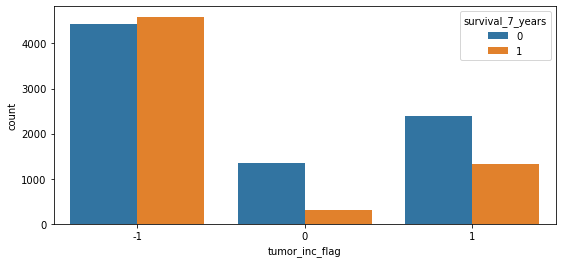

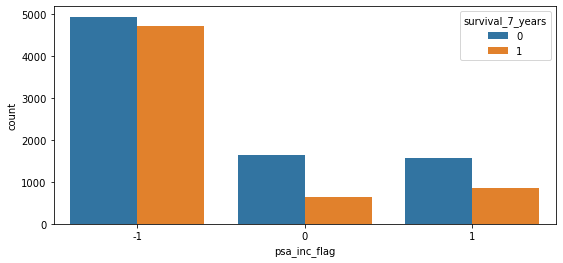

In [18]:
plt.figure(figsize=(9,4))
print(sns.countplot(train['tumor_inc_flag'],hue=train['survival_7_years']))
plt.figure(figsize=(9,4))
print(sns.countplot(train['psa_inc_flag'],hue=train['survival_7_years']))

# Dropping unwanted columns 
"we have already created some feature from them psa_inc_flag, tumor_inc_flag, tumor_inc, psa_inc "

In [19]:
# Drop Values ---->

train.drop(['id','tumor_6_months','psa_6_months','psa_diagnosis','tumor_diagnosis','tumor_1_year','psa_1_year'],axis=1,inplace=True)
test.drop(['id','tumor_6_months','psa_6_months','psa_diagnosis','tumor_diagnosis','tumor_1_year','psa_1_year'],axis=1,inplace=True)

In [20]:
# unique values ---->

train.select_dtypes(include=np.number).nunique()

gleason_score            11
age                      72
race                      4
height                    9
weight                  154
family_history            6
first_degree_history      5
previous_cancer           2
smoker                    2
tea                      12
rd_thrpy                  2
h_thrpy                   2
chm_thrpy                 2
cry_thrpy                 2
brch_thrpy                2
rad_rem                   2
multi_thrpy               2
survival_1_year           2
survival_7_years          2
psa_inc                 693
tumor_inc               149
tumor_inc_flag            3
psa_inc_flag              3
dtype: int64

In [21]:
# info  --->

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14385 entries, 0 to 14384
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   diagnosis_date        14385 non-null  object 
 1   gleason_score         14080 non-null  float64
 2   t_score               14385 non-null  object 
 3   n_score               14385 non-null  object 
 4   m_score               14385 non-null  object 
 5   stage                 14385 non-null  object 
 6   age                   13697 non-null  float64
 7   race                  14231 non-null  float64
 8   height                13128 non-null  float64
 9   weight                13158 non-null  float64
 10  family_history        12903 non-null  float64
 11  first_degree_history  12903 non-null  float64
 12  previous_cancer       12903 non-null  float64
 13  smoker                12903 non-null  float64
 14  side                  14385 non-null  object 
 15  tea                

# Describe & Capping/Floaring 
# Outlier Treatment 

In [24]:
# Capping/Floaring ---->

    #1) gleason_score 0, 99.5
    #2) age 0.3, 99.5
    #3) height 0 , 100
    #4) weight 0.3,99.5
    #5) tumor_diagnosis 0.3, 99
    #6) psa_diagnosis 0, 99.5
    #7) tea 0 , 99.5
train[train.select_dtypes(include=np.number).nunique()[train.select_dtypes(include=np.number).nunique()>=6].index].describe(percentiles=[0.003,0.005,.02,.03,.05,.95,.97,.98,.99,.995])

,gleason_score,age,height,weight,family_history,tea,psa_inc,tumor_inc
count,14080.000000,13697.000000,13128.000000,13158.000000,12903.000000,12903.000000,14385.000000,14353.000000
mean,7.298509,76.896109,69.152803,176.808482,0.425637,2.552120,-2.040709,-9.700550
std,1.933190,9.637021,1.126814,17.118949,0.614782,1.616137,3.383410,20.672944
min,3.000000,32.000000,65.000000,118.000000,0.000000,0.000000,-14.300000,-77.000000
0.3%,3.000000,48.000000,66.000000,139.471000,0.000000,0.000000,-10.600000,-58.000000
0.5%,3.000000,50.000000,66.000000,143.000000,0.000000,0.000000,-10.100000,-55.000000
2%,3.000000,55.000000,67.000000,150.000000,0.000000,0.000000,-8.500000,-46.000000
3%,3.000000,57.000000,67.000000,152.000000,0.000000,0.000000,-7.900000,-43.000000
5%,4.000000,59.000000,67.000000,155.000000,0.000000,0.000000,-7.200000,-40.000000
50%,7.000000,78.000000,69.000000,174.000000,0.000000,2.000000,-1.800000,-10.000000


In [25]:
# family_history 0,99.5
# first_degree_history 99.5

train[train.select_dtypes(include=np.number).nunique()[train.select_dtypes(include=np.number).nunique()<=6].index].describe(percentiles=[0.003,0.005,.02,.03,.05,.95,.97,.98,.99,.995])

,race,family_history,first_degree_history,previous_cancer,smoker,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,survival_7_years,tumor_inc_flag,psa_inc_flag
count,14231.000000,12903.000000,12903.000000,12903.000000,12903.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000,14385.000000
mean,3.481976,0.425637,0.212044,0.068589,0.054173,0.537643,0.341189,0.663538,0.239625,0.246090,0.174835,0.778450,0.895655,0.432186,-0.367883,-0.501495
std,0.952237,0.614782,0.460655,0.252763,0.226368,0.498598,0.474125,0.472515,0.426869,0.430746,0.379839,0.415304,0.305718,0.495397,0.865671,0.768009
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
0.3%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
0.5%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
2%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
3%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
5%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000


In [26]:
# Function for Outlier Treatment---->

def outlier_treatment(df,col,maxlim,minlim):
    maxlim=np.percentile(df[col].dropna(),maxlim)
    minlim=np.percentile(df[col].dropna(),minlim)
    test.loc[test[test[col]>maxlim].index,col]=maxlim  # Test
    test.loc[test[test[col]<minlim].index,col]=minlim  # test
    df.loc[df[df[col]>maxlim].index,col]=maxlim
    df.loc[df[df[col]<minlim].index,col]=minlim

In [27]:
# train.family_history.value_counts()
# sns.countplot(train['family_history'],hue=train['survival_7_years'])
# train.first_degree_history.value_counts()
# sns.countplot(train['first_degree_history'],hue=train['survival_7_years'])

In [28]:
outlier_treatment(train,'gleason_score',99.5,0)
outlier_treatment(train,'age',99.5,0.3)
outlier_treatment(train,'weight',99.5,0.3)
outlier_treatment(train,'tea',99.5,0)
outlier_treatment(train,'family_history',99.5,0) # treating as member more than 3 is 3
outlier_treatment(train,'first_degree_history',99.5,0) # treating as member more than 2 is 2

# Missing Value Imputation

In [29]:
# Creating YEAR, Month

train['dt_year']=pd.to_datetime(train['diagnosis_date']).dt.year
train['dt_month']=pd.to_datetime(train['diagnosis_date']).dt.month

In [30]:
# plt.figure(figsize=(9,4))
# sns.countplot(final_data.diagnosis_date.dt.year,hue=final_data.survival_7_years)
# plt.figure(figsize=(9,4))
# sns.countplot(final_data.diagnosis_date.dt.month,hue=final_data.survival_7_years)

In [31]:
# Check the distribution ---->

train.gleason_score.value_counts(normalize=True,dropna=False);

In [35]:
# filling by mean : age, height, weight, tumor_diagnosis, psa_diagnosis
# filling by mode : family_history, first_degree_history, previous_cancer, smoker, tea
# filling by others : symptoms
def fillna_(df,cols,type='mean'):
    for col in cols:
        if type=='mean':
            df[col]=df[col].fillna(df[col].mean())
            test[col]=test[col].fillna(df[col].mean())
        elif type=='mode':
            df[col]=df[col].fillna(df[col].mode()[0])
            test[col]=test[col].fillna(df[col].mode()[0])
        else:
            df[col]=df[col].fillna('others')
            test[col]=test[col].fillna('others')

In [36]:
fillna_(train,['age','height', 'weight'])
fillna_(train,['family_history', 'first_degree_history', 'previous_cancer', 'smoker', 'tea','race','gleason_score'],type='mode')
fillna_(train,['symptoms'],type='other')

In [37]:
# creating BMI from height/weight/age
# BMI = weight kg/height in meter *height in meter

train['bmi']=train['weight']*.4536/(train['height']*.0254)**2
train['bmi']=np.where(train['bmi']<25,0,(np.where(train['bmi']<30,1,2)))
train[['weight','height','bmi']].corr();

# Age Categorical 

In [38]:
age_dict=dict(zip(np.percentile(train.age,range(0,101,10)),[0,1,2,3,4,5,6,7,8,9,10]))

In [39]:
def get_age(x):
    temp=48
    for i in age_dict.keys():
        if x>i:
            temp=i
        else:
            break
    return age_dict[temp]

In [40]:
train['u_age']=train['age'].apply(lambda x:get_age(x))
test['u_age']=test['age'].apply(lambda x:get_age(x))

In [41]:
# plt.figure(figsize=(9,4))
# sns.countplot(train['u_age'],hue=train['survival_7_years']);

In [42]:
# weight_dict=dict(zip(np.percentile(train.weight,range(0,101,10)),[0,1,2,3,4,5,6,7,8,9,10]))
# def get_weight(x):
#     temp=139.471
#     for i in weight_dict.keys():
#         if x>i:
#             temp=i
#         else:
#             break
#     return weight_dict[temp]
# train['u_weight']=train['weight'].apply(lambda x:get_weight(x))
# plt.figure(figsize=(16,9))
# sns.countplot(train['u_weight'],hue=train['survival_7_years'])

In [43]:
train['u_weight']=(train.weight).apply(lambda x:str(np.floor(x))[:4]).astype(np.number)

In [44]:
train.isna().sum()[train.isna().sum()>0]/len(train)

tumor_inc    0.002225
dtype: float64

In [45]:
test.isna().sum()[test.isna().sum()>0]/len(test)

Series([], dtype: float64)

In [46]:
for i in train.select_dtypes(include=object).columns:
    print(f'{i} : {train[i].value_counts()}')

diagnosis_date : 2006-02-01    319
2006-11-01    312
2006-12-01    307
2006-10-01    295
2005-12-01    285
             ... 
2001-06-01     81
2001-07-01     80
2000-08-01     73
2000-06-01     65
2000-07-01     62
Name: diagnosis_date, Length: 79, dtype: int64
t_score : T4     3872
T3b    1498
T3a    1476
T3c    1394
T2a    1222
T2b    1174
T2c    1171
T1c     877
T1a     865
T1b     836
Name: t_score, dtype: int64
n_score : N0    8974
N1    3968
NX    1443
Name: n_score, dtype: int64
m_score : M0     13256
M1c      440
M1a      406
M1b      283
Name: m_score, dtype: int64
stage : IV     6282
IIB    3217
III    2459
IIA    1926
I       501
Name: stage, dtype: int64
side : both     7234
right    4327
left     2824
Name: side, dtype: int64
symptoms : U01,U02                    740
U01                        599
U02                        523
U01,U02,S07                503
U01,S07                    418
                          ... 
S07,P03,O01,O10              1
U02,U03,O01,O11        

# Categorical Value Treatment 
# Encoding 

In [47]:
for i in train.select_dtypes(include=object).columns:
    print(f'{i} : {train[i].unique()[:12]}')

diagnosis_date : ['2005-06-01' '2006-02-01' '2006-03-01' '2005-02-01' '2001-12-01'
 '2001-07-01' '2005-10-01' '2005-12-01' '2004-01-01' '2004-11-01'
 '2006-01-01' '2003-08-01']
t_score : ['T1c' 'T3a' 'T1a' 'T2b' 'T4' 'T1b' 'T3b' 'T3c' 'T2c' 'T2a']
n_score : ['N0' 'N1' 'NX']
m_score : ['M0' 'M1c' 'M1b' 'M1a']
stage : ['I' 'IV' 'IIB' 'IIA' 'III']
side : ['both' 'right' 'left']
symptoms : ['U03' 'U06,S07' 'U01,U02,U03,S10' 'U01,U02,S10,O11' 'U01,U03,U05,S07'
 'U02,U03,S10' 'U01,U02,U03,S07' 'U01,U02,U03' 'U02,U03,O11'
 'U01,U02,U03,S07,O11' 'U01,U03' 'U01,U02,S04']


In [48]:
train['symptoms_count']=train['symptoms'].apply(lambda x:len(x.split(',')))

In [49]:
# plt.figure(figsize=(9,4))
# sns.countplot(train['side'],hue=train['survival_7_years'])
# plt.figure(figsize=(9,4))
# sns.countplot(train['stage'],hue=train['survival_7_years'])
# plt.figure(figsize=(9,4))
# sns.countplot(train['symptoms_count'],hue=train['survival_7_years'])

In [50]:
# Labal Encoding 

train['u_stage']=train['stage'].map({'I':0 ,'IV':4 ,'IIB':2 ,'IIA':1 ,'III':3}) 
test['u_stage']=test['stage'].map({'I':0 ,'IV':4 ,'IIB':2 ,'IIA':1 ,'III':3}) 

In [51]:
sym_list = set(re.findall(r"[\w']+", ' '.join(train.symptoms.dropna())))

In [52]:
def retur_sys(x):
    temp = x.split(',')
    dic={}
    for i in sym_list:
        dic[i]=int(i in temp)
    return dic

In [53]:
# One Host Encoding 

oe = OneHotEncoder(drop='first') 

# Final Dataset

In [54]:
# Concate All Dataset 
    #1) Cateorical Values
    #2) Remaning Data
    #3) symptoms Variable
final_data = pd.concat([pd.DataFrame(oe.fit_transform(train[['t_score','n_score','m_score','side']]).toarray(),columns=oe.get_feature_names(['t_score','n_score','m_score','side'])),train.drop(['diagnosis_date','t_score','symptoms','side','m_score','n_score'],axis=1),pd.DataFrame(dict(train.symptoms.apply(lambda x : retur_sys(x)))).T],axis=1)

In [55]:
final_test = pd.concat([pd.DataFrame(oe.fit_transform(test[['t_score','n_score','m_score','side']]).toarray(),columns=oe.get_feature_names(['t_score','n_score','m_score','side'])),test.drop(['diagnosis_date','t_score','symptoms','side','m_score','n_score'],axis=1),pd.DataFrame(dict(test.symptoms.apply(lambda x : retur_sys(x)))).T],axis=1)

In [56]:
print(f'Train DataFrame Shape is {final_data.shape} and Test DataFrame Shape is {final_test.shape}')

Train DataFrame Shape is (14385, 64) and Test DataFrame Shape is (1000, 56)


# Correlation DataSet / Dropping Correlation Values>0.6

In [57]:
train.drop(['multi_thrpy','tumor_inc','age','weight','height','first_degree_history','tumor_inc_flag','psa_inc_flag','dt_month','bmi','u_weight'],axis=1).corr()

,gleason_score,race,family_history,previous_cancer,smoker,tea,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,survival_1_year,survival_7_years,psa_inc,dt_year,u_age,symptoms_count,u_stage
gleason_score,1.000000,0.008137,0.050983,0.031446,-0.002068,0.010827,0.109893,0.122582,-0.037942,-0.063878,-0.120365,0.117223,-0.058335,-0.158033,0.309063,0.011763,0.033640,0.018900,0.167749
race,0.008137,1.000000,0.003144,0.002606,-0.100470,-0.111198,-0.000072,0.007303,0.012657,-0.003689,-0.005925,0.000170,0.020561,0.008296,0.011801,0.006401,-0.005487,-0.008119,0.006823
family_history,0.050983,0.003144,1.000000,0.032784,0.019588,0.031063,0.002309,0.006194,-0.008180,-0.007622,-0.014493,0.005033,-0.014003,-0.014130,0.078335,0.007228,-0.000966,-0.010039,0.008888
previous_cancer,0.031446,0.002606,0.032784,1.000000,0.013450,-0.000249,0.004170,0.014064,-0.000142,-0.013601,-0.000530,-0.008934,-0.008191,-0.017804,0.034874,0.002328,-0.008538,0.012693,0.011372
smoker,-0.002068,-0.100470,0.019588,0.013450,1.000000,0.044439,-0.003121,-0.003744,0.008339,-0.008709,0.001489,-0.004434,-0.019103,0.011684,-0.009838,-0.017372,0.013183,0.013961,0.004585
tea,0.010827,-0.111198,0.031063,-0.000249,0.044439,1.000000,0.004558,0.010948,0.005881,0.002403,-0.007515,0.006705,-0.019311,-0.013025,0.003790,0.001866,-0.004083,0.007638,-0.004921
rd_thrpy,0.109893,-0.000072,0.002309,0.004170,-0.003121,0.004558,1.000000,0.207698,0.046681,-0.129762,-0.135715,-0.144696,-0.069780,-0.132716,0.067032,-0.012892,0.009650,0.013203,0.218175
h_thrpy,0.122582,0.007303,0.006194,0.014064,-0.003744,0.010948,0.207698,1.000000,-0.141707,-0.059453,-0.063932,-0.015476,0.014449,0.019189,0.051815,-0.011526,0.009202,-0.035177,-0.100465
chm_thrpy,-0.037942,0.012657,-0.008180,-0.000142,0.008339,0.005881,0.046681,-0.141707,1.000000,-0.156557,-0.185790,-0.219550,-0.044771,-0.083521,-0.003132,-0.012614,-0.011142,0.058542,0.511657
cry_thrpy,-0.063878,-0.003689,-0.007622,-0.013601,-0.008709,0.002403,-0.129762,-0.059453,-0.156557,1.000000,-0.073453,-0.016575,0.018473,0.057616,-0.041699,-0.000371,-0.005609,-0.029759,-0.316875


<AxesSubplot:>

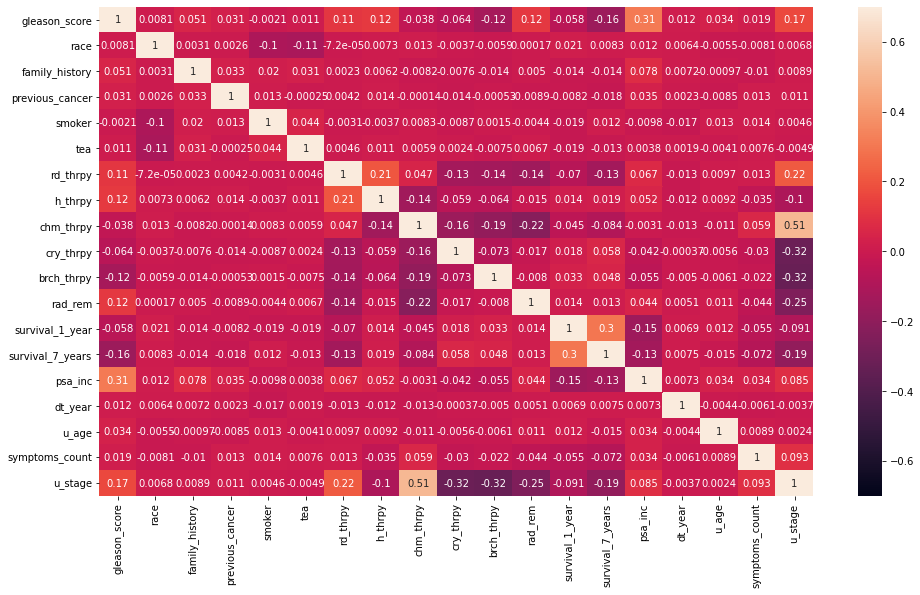

In [78]:
plt.figure(figsize=(16,9))
sns.heatmap(train.drop(['multi_thrpy','tumor_inc','age','weight','height','first_degree_history','tumor_inc_flag','psa_inc_flag','dt_month','bmi','u_weight'],axis=1).corr(),vmin=-.7,vmax=.7,annot=True)

In [59]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14385 entries, 0 to 14384
Data columns (total 64 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   t_score_T1b           14385 non-null  float64
 1   t_score_T1c           14385 non-null  float64
 2   t_score_T2a           14385 non-null  float64
 3   t_score_T2b           14385 non-null  float64
 4   t_score_T2c           14385 non-null  float64
 5   t_score_T3a           14385 non-null  float64
 6   t_score_T3b           14385 non-null  float64
 7   t_score_T3c           14385 non-null  float64
 8   t_score_T4            14385 non-null  float64
 9   n_score_N1            14385 non-null  float64
 10  n_score_NX            14385 non-null  float64
 11  m_score_M1a           14385 non-null  float64
 12  m_score_M1b           14385 non-null  float64
 13  m_score_M1c           14385 non-null  float64
 14  side_left             14385 non-null  float64
 15  side_right         

In [60]:
final_data.columns

Index(['t_score_T1b', 't_score_T1c', 't_score_T2a', 't_score_T2b',
       't_score_T2c', 't_score_T3a', 't_score_T3b', 't_score_T3c',
       't_score_T4', 'n_score_N1', 'n_score_NX', 'm_score_M1a', 'm_score_M1b',
       'm_score_M1c', 'side_left', 'side_right', 'gleason_score', 'stage',
       'age', 'race', 'height', 'weight', 'family_history',
       'first_degree_history', 'previous_cancer', 'smoker', 'tea', 'rd_thrpy',
       'h_thrpy', 'chm_thrpy', 'cry_thrpy', 'brch_thrpy', 'rad_rem',
       'multi_thrpy', 'survival_1_year', 'survival_7_years', 'psa_inc',
       'tumor_inc', 'tumor_inc_flag', 'psa_inc_flag', 'dt_year', 'dt_month',
       'bmi', 'u_age', 'u_weight', 'symptoms_count', 'u_stage', 'P01', 'U03',
       'U05', 'P02', 'O09', 'P03', 'O01', 'O10', 'S07', 'O11', 'U06', 'O08',
       'S10', 'others', 'U01', 'S04', 'U02'],
      dtype='object')

# Dropping Columns from Multiple ITERATION 

In [61]:
drop=['survival_7_years','weight','age','dt_month','dt_year','stage','symptoms_count','psa_inc_flag','tumor_inc_flag','weight','height','family_history','first_degree_history']
drop.extend(['multi_thrpy','tumor_inc','age','weight','height','first_degree_history','tumor_inc_flag','psa_inc_flag','dt_month','bmi','u_weight'])
drop.extend(['S04', 'O11', 'S10', 'P01', 'O01','O09','O10','U01','U03','others','U06'])
drop.extend(['t_score_T3b', 'previous_cancer', 't_score_T2b', 'side_left','t_score_T2a', 'smoker'])

X=final_data.drop(drop,axis=1)
Y=final_data['survival_7_years']

In [62]:
X.shape,Y.shape

((14385, 31), (14385,))

In [63]:
X.isna().sum().sum()

0

In [64]:
# Test Train Split 

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.1,random_state=42)

In [65]:
# Classifier 

xg=xgboost.XGBClassifier(max_depth=10,learning_rate=.001,n_estimators=700,min_child_weight=.8,subsample=.7,random_state=42)

In [66]:
xg.fit(X,Y)

[13:36:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=10,
              min_child_weight=0.8, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [67]:
test['survival_7_years']=xg.predict(final_test[x_test.columns])

In [68]:
test['survival_7_years'].value_counts(normalize=True)

1    0.524
0    0.476
Name: survival_7_years, dtype: float64

In [77]:
# test.to_csv('result.csv',index=False)

# Matrix 

In [ ]:
confusion_matrix(y_test,xg.predict(x_test))

In [ ]:
print(accuracy_score(y_test,xg.predict(x_test))) 
print(recall_score(y_test,xg.predict(x_test)))
print(precision_score(y_test,xg.predict(x_test)))

# Freature IMP

In [72]:
pd.DataFrame(xg.feature_importances_,x_test.columns).reset_index().rename(columns={'index':'feature_name',0:'importance'}).sort_values(by='importance',ascending=False).reset_index(drop=True)

,feature_name,importance
0,survival_1_year,0.569703
1,n_score_N1,0.284378
2,rd_thrpy,0.032531
3,gleason_score,0.011226
4,P03,0.006580
5,U05,0.006294
6,O08,0.006155
7,m_score_M1b,0.005273
8,P02,0.005177
9,m_score_M1c,0.004564


# Feature Selection 

In [73]:
result=permutation_importance(xg,x_test,y_test,n_repeats=10,random_state=42)
f_result = pd.DataFrame(result.importances_mean,x_test.columns).reset_index().rename(columns={'index':'feature_name',0:'importance'}).sort_values(by='importance')
f_result['importance']=f_result['importance']*1000
f_result.reset_index(drop=True)

,feature_name,importance
29,O08,0.138985
27,P03,0.138985
1,t_score_T1c,0.347464
18,cry_thrpy,0.694927
8,m_score_M1a,1.250869
4,t_score_T3c,1.389854
9,m_score_M1b,1.598332
24,u_stage,1.598332
0,t_score_T1b,1.737318
10,m_score_M1c,1.876303


In [74]:
# Drop List -- Feature Selection 

f_result[f_result['importance']<0]['feature_name'].values

array([], dtype=object)

In [89]:
x_train.shape

(12946, 31)

In [ ]:
#xg=xgboost.XGBClassifier(max_depth=10,learning_rate=.001,n_estimators=700,min_child_weight=.8,subsample=.7,random_state=42)
xg.score(X,Y)

# GridSearchCV 

In [ ]:
param = {'max_depth': range(6,18,1), 
         'n_estimators':range(200,800,100), 
          'learning_rate':[.1,.01,.001,.05],
           'min_child_weight':[.5,.6,.7,.8,.9],
         'subsample':[.5,.6,.7,.8,.9],
         
        }
rnd_search = RandomizedSearchCV(xgboost.XGBClassifier(random_state=42), param, n_iter =100, cv=5,n_jobs=-1,verbose=10)
rnd_search.fit(X,Y)
rnd_search.best_params_
rnd_search.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 26

In [76]:
rnd_search.best_params_

{'max_depth': 10,
 'learning_rate': 0.001,
 'n_estimators': 700,
 'min_child_weight': 0.8,
 'subsample': 0.7,
 'random_state': 42}

In [116]:
#pd.DataFrame(rnd_search.cv_results_).to_csv('cv_resut.csv',index=False)